# 勾配降下法Gradien descent使用(TV正則化)

proxg=Noneにすれば勾配降下法gradient descentになる(ただしTVの正則化項も無視される)

proxg=proxgにすると、近接勾配法になる。

そうした上で、accelerate=True　とするとFISTAになる


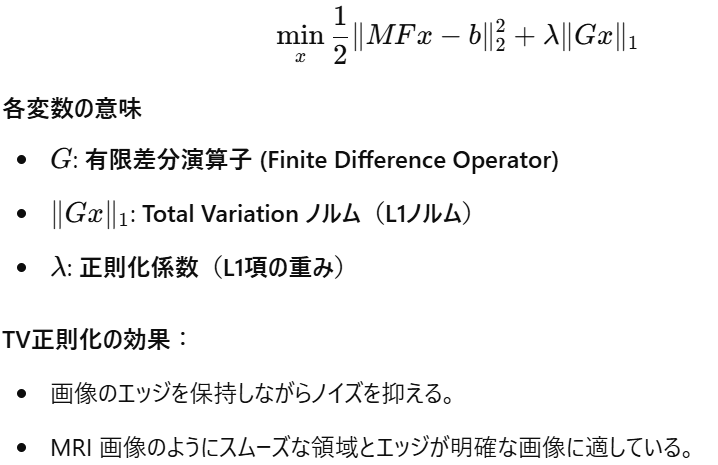

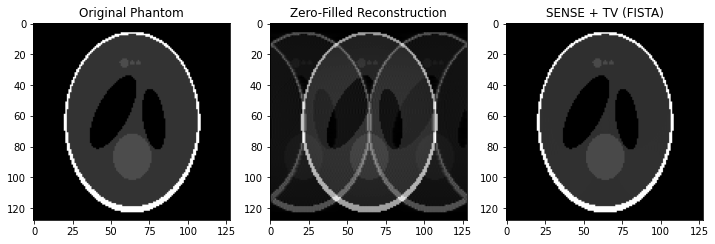

In [1]:
import sigpy as sp
import sigpy.mri as mri
import numpy as np
import matplotlib.pyplot as plt

# Shepp-Logan Phantom の作成
N = 128  # 画像サイズ
img_shape = (N, N)
phantom = sp.shepp_logan(img_shape)

# コイル感度マップの生成 (birdcage model, 4 coils)
num_coils = 4
mps = mri.birdcage_maps((num_coils, *img_shape))  # (4, 128, 128)

# k-space の計算 (各コイルごとに感度をかけて Fourier 変換)
ksp = np.array([sp.fft(phantom * mps[i], axes=(-1, -2)) for i in range(num_coils)])

# 1D undersampling マスク（位相エンコード方向のみ間引く）
mask = np.ones(img_shape)  # 全体を 1 で初期化
mask[:, ::3] = 0  # 3倍加速 (位相エンコード方向で1/3のサンプルのみ使用)
ksp_sampled = ksp * mask  # 各コイルに適用

# FFT 演算子（axes を明示的に指定）
F = sp.linop.FFT(ksp.shape, axes=(-1, -2))

# 感度マップ適用演算子 (num_coils の次元を考慮)
S = sp.linop.Multiply(img_shape, mps)

# サンプリングマスク演算子 (num_coils, Ny, Nx の形で mask を適用)
P = sp.linop.Multiply(ksp.shape, mask)

# SENSE の線形オペレータ
A = P * F * S  # 順方向モデル

# TV 正則化オペレータ（x, y 方向の微分）
G = sp.linop.FiniteDifference(img_shape, axes=[0, 1])  # TV 正則化演算子

# TV 正則化のプロキシマル演算 (L1正則化)
lambda_tv = 0.01  # TV正則化の強さ
proxg = sp.prox.L1Reg(img_shape, lambda_tv)

# コスト関数の勾配（データフィデリティ項）
def grad_func(x):
    return A.H * (A * x - ksp_sampled)  # A^H (A x - b)

# 初期値（ゼロフィルド画像）
img_zero_filled = np.sum(sp.ifft(ksp_sampled, axes=(-1, -2)), axis=0)
x_init = np.copy(img_zero_filled)

# FISTA (Accelerated Proximal Gradient Descent)
step_size = 0.5  # 学習率
max_iter = 100  # 最大イテレーション数

fista_solver = sp.alg.GradientMethod(
    gradf=grad_func,
    x=x_init,
    alpha=step_size,
    proxg=proxg,  # TV 正則化のプロキシマル演算
    max_iter=max_iter,
    accelerate=True  # True: FISTA, False: ISTA
)

# 画像再構成
while not fista_solver.done():
    fista_solver.update()

# 結果を取得
reconstructed_img = np.abs(x_init)

# 結果を可視化
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(np.abs(phantom), cmap="gray")
axs[0].set_title("Original Phantom")
axs[1].imshow(np.abs(img_zero_filled), cmap="gray")
axs[1].set_title("Zero-Filled Reconstruction")
axs[2].imshow(reconstructed_img, cmap="gray")
axs[2].set_title("SENSE + TV (FISTA)")
plt.show()
